In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import ipywidgets as widgets
from matplotlib.patches import Rectangle

In [2]:
#Pulling in pre binned data to combine w ids

ids = np.load("../../data/spike_clusters.npy")
# binned_spikes = np.load("../../data/binned_20ms.npy")
# spike_data =  pd.DataFrame(binned_spikes)
# spike_data

# To pull out stim data
stim_on_time = np.load("../../data/natImsOnTimes.npy")
stim_on_time
#to bin: divide by 20, floor
stim_binned = np.floor(stim_on_time*1000 /20)
stim_binned = np.transpose(stim_binned)
stim_ids = np.load("../../data/natImsIDs.npy") # max is 10
stims = np.vstack((stim_binned, stim_ids))
# stims = pd.DataFrame(stims)
# stims.columns = stims.iloc[0]
# stims = stims.drop(0)

# stim_ids

In [69]:
binned_spikes = np.load('../../data/binned_20ms_2.npy')

In [70]:
binned_spikes.shape

(753, 168463)

In [91]:
# Load binned_spikes
# binned_spikes = np.load("../../data/binned_20ms.npy")
binned_spikes = np.load('../../data/binned_20ms_2.npy')

# To pull out stim data
stim_on_time = np.load("../../data/natImsOnTimes.npy")

# To bin: divide by 20, floor
stim_binned = np.floor(stim_on_time * 1000 / 20).astype(int)
stim_binned = np.transpose(stim_binned)
stim_ids = np.load("../../data/natImsIDs.npy")  # max is 10
stims = np.vstack((stim_binned, stim_ids))

u_stim_ids = np.unique(stim_ids)

# Initialize final_avg matrix
final_avg = np.empty((binned_spikes.shape[0], 10, 31))

for neuron_id in range(binned_spikes.shape[0]):

    for stim_id in u_stim_ids:
        stim_indices = np.where(stims[1] == stim_id)[0]

        neuron_stim_data = np.empty((len(stim_indices), 31))
        
        for i, stim_idx in enumerate(stim_indices):
            bin_id = int(stim_binned[0][stim_idx])
            selected_columns = binned_spikes[neuron_id, bin_id - 5: bin_id + 26]
            neuron_stim_data[i,:] = selected_columns

        bin_average = np.mean(neuron_stim_data, axis=0)
        final_avg[neuron_id, int(stim_id) - 1, :] = bin_average

final_avg

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.00666667, 0.        , 0.        , ..., 0.00666667,
         0.        , 0.00666667],
        [0.        , 0.        , 0.        , ..., 0.00666667,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.00666667, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.00666667,
         0.        , 0.        ]],

       [[0.03333333, 0.04      , 0.06      , ..., 0.07333333,
         0.08666667, 0.02666667],
        [0.03333333, 0.06      , 0.04666667, ..., 0.03333333,
         0.06666667, 0.03333333],
        [0.04666667, 0.06      , 0.04666667, ..., 0.08666667,
         0.08666667, 0.06      ],
        ...,
        [0.06666667, 0.04      , 0.03333333, ..., 0.06      ,
         0.03333333, 0.02      ],
        [0.0

In [101]:
#TESTING WHERE THE PROBLEM IS
binned_spikes = np.load('../../data/binned_20ms_2.npy')
# To pull out stim data
stim_on_time = np.load("../../data/natImsOnTimes.npy")

# To bin: divide by 20, floor
stim_binned = np.floor(stim_on_time * 1000 / 20).astype(int)
stim_binned = np.transpose(stim_binned)
stim_ids = np.load("../../data/natImsIDs.npy")  # max is 10

u_stim_ids = np.unique(stim_ids)

# Initialize final_avg matrix
final_avg_test = np.empty((binned_spikes.shape[0], 10, 31))

for neuron_id in range(binned_spikes.shape[0]):

    for stim_id in u_stim_ids:
        stim_indices = np.where(stim_ids[0] == stim_id)[0]

        neuron_stim_data = np.empty((len(stim_indices), 31))
        
        for i, stim_idx in enumerate(stim_indices):
            bin_id = int(stim_binned[0][stim_idx])
            selected_columns = binned_spikes[neuron_id, bin_id - 5: bin_id + 26]
            neuron_stim_data[i,:] = selected_columns

        bin_average = np.mean(neuron_stim_data, axis=0)
        final_avg_test[neuron_id, int(stim_id) - 1, :] = bin_average

# final_avg_test

In [98]:
#Assumptions: spiking data in 20 ms bins, stim data in seconds
# LOAD FILES BEFORE
# DEFINE IN SECONDS - 0.02 BINS, 0.1 + 0.5 WINDOWS
# if prev and post aren't exact intervals, flash warning and find nearest bin
def create_graphing_data(binned_spikes, stim_on_time, stim_ids, bin_size=20, bintime_prev = 5, bintime_post = 26):
    
    # To convert stim on time to bin time for spiking data
    stim_binned = np.floor(stim_on_time * 1000 / bin_size).astype(int)
    stim_binned = np.transpose(stim_binned)

    # pulling out the list of stimuli
    u_stim_ids = np.unique(stim_ids)
    windowsize = bintime_prev + bintime_post

    # initializing final_avg matrix
    final_avg = np.empty((binned_spikes.shape[0], len(u_stim_ids), windowsize))

    # starting for loop for calculations:
    for neuron_id in range(binned_spikes.shape[0]):
        for stim_id in u_stim_ids:
            stim_indices = np.where(stim_ids[0] == stim_id)[0]

            neuron_stim_data = np.empty((len(stim_indices), windowsize))
            
            for i, stim_idx in enumerate(stim_indices):
                bin_id = int(stim_binned[0][stim_idx])
                selected_columns = binned_spikes[neuron_id, bin_id - bintime_prev: bin_id + bintime_post]
                neuron_stim_data[i,:] = selected_columns

            bin_average = np.mean(neuron_stim_data, axis=0)
        final_avg[neuron_id, int(stim_id) - 1, :] = bin_average
    return final_avg


In [99]:
binned_spikes = np.load('../../data/binned_20ms_2.npy')
stim_on_time = np.load("../../data/natImsOnTimes.npy")
stim_ids = np.load("../../data/natImsIDs.npy") 
test = create_graphing_data(binned_spikes,stim_on_time,stim_ids)
test

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.00666667,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [ ]:
#for each neuron
    #for each stim id
        #create intermediate array stim_intermediate
        #for all of stimulus times
            #if stim id = current stim we're looking at
                #pull timeframe into stim_intermediate
        #average vertically across stim_intermediaten -> returns average for neuron a for all of stimulus x
        #add average to final array (?) 


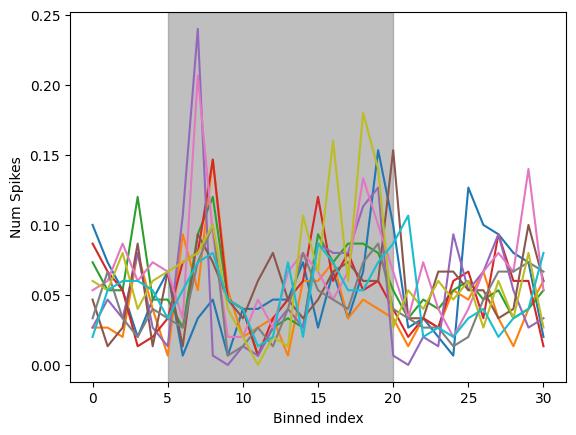

In [102]:
for i in range(0,10):
    y = final_avg_test[36][i]
    plt.plot(y)
# Assuming combined is your DataFrame
# y = final_avg[0][5]  # Adjusted slicing indices
 # Adjusted slicing indices


plt.xlabel('Binned index')
plt.ylabel('Num Spikes')
#plt.title('Stimulus id:{}, bin: {}'.format(stim_id, bin_id))

# Add the gray rectangle
plt.axvspan(5, 20, color='gray', alpha=0.5)

plt.show()


IndexError: index 753 is out of bounds for axis 0 with size 753

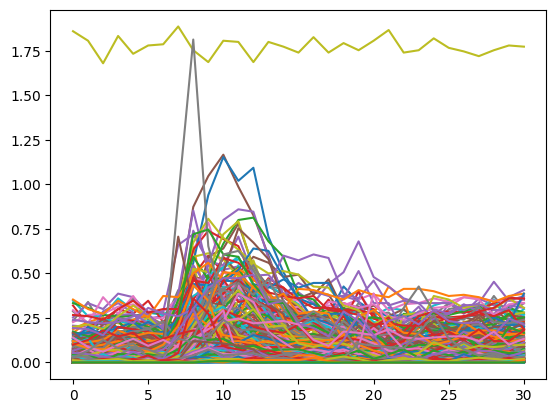

In [76]:
for i in range(0,779):
    y = final_avg[i][5]
    plt.plot(y)
# Assuming combined is your DataFrame
# y = final_avg[0][5]  # Adjusted slicing indices
 # Adjusted slicing indices


plt.xlabel('Binned index')
plt.ylabel('Num Spikes')
# plt.title('Stimulus id:{}, bin: {}'.format(stim_id, bin_id))

# Add the gray rectangle
plt.axvspan(5, 20, color='gray', alpha=0.5)

plt.show()


In [63]:
tot_neuron_avg.to_csv("../../data/tot_neuron_avg.csv")

In [14]:
# Combining the dfs
combined = spike_data.merge(stims, how = "outer")
combined = combined.rename(index={799: 'stim'})
combined

,0,1,2,3,4,5,6,7,8,9,...,161525,161526,161527,161528,161529,161530,161531,161532,161533,161534
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


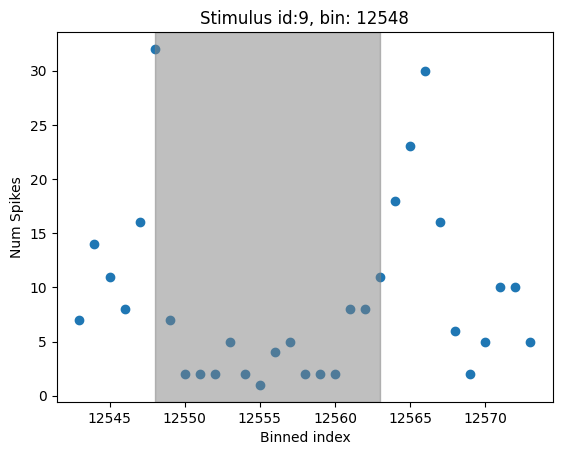

In [15]:
bin_id = 12548
stim_id = int(combined.iloc[779,bin_id])
# Assuming combined is your DataFrame
x = combined.columns[bin_id - 5: bin_id + 26].to_list()  # Adjusted slicing indices
#x = [i * 20 for i in x]
y = combined.iloc[:, bin_id - 5: bin_id + 26].sum().to_list()  # Adjusted slicing indices

plt.scatter(x, y)
plt.xlabel('Binned index')
plt.ylabel('Num Spikes')
plt.title('Stimulus id:{}, bin: {}'.format(stim_id, bin_id))

# Add the gray rectangle
plt.axvspan(bin_id, bin_id + 15, color='gray', alpha=0.5)

plt.show()


In [3]:
allen = pd.read_csv("../../data/allen_visual_behavior_firing_rate.csv")
allen = allen.iloc[::400]


In [133]:
def slope_viz_neurons(t=0):
    t = int(t)
    if t<25:
        x = spike_data.columns[0:25].to_list()
        y = spike_data.iloc[:,0:25].sum().to_list()
    else:
        x = spike_data.columns[t-50:t+50].to_list()
        y = spike_data.iloc[:,t-50:t+50].sum().to_list()
    plt.scatter(x, y, label='Spikes')
    plt.axvline(t, color='red', linestyle='--',)
    plt.xlabel('Time(in 20ms bins)')
    plt.ylabel('Num Spikes')
    plt.legend()
    plt.show()
    print(len(x))
    print(len(y))

probably smoother to have the line move than to have the entire graph move, maybe pass in edges of the graphs as parameters?
def add more widget functions to the ui to clean it up
need to combine with image dataset, maybe transparent boxes or something?
should data be put into bigger bins?

In [134]:
slider = widgets.FloatSlider(value=0.0, min=0.0, max=500.0, step=5.0, description='Time')
slider.layout.width = "100%"
widgets.interact(slope_viz_neurons, t=slider)

interactive(children=(FloatSlider(value=0.0, description='Time', layout=Layout(width='100%'), max=500.0, step=…

<function __main__.slope_viz_neurons(t=0)>